This is just a test

In [1]:
from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, SimpleRNN, RepeatVector, TimeDistributed, Dense, Input, Lambda
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import timedelta
import time

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print("Avaiable tensorflow devices")
for d in device_lib.list_local_devices():
    print(" ->", d.name, "is a", d.device_type, "(", d.physical_device_desc, ")")

Avaiable tensorflow devices
 -> /device:CPU:0 is a CPU (  )
 -> /device:XLA_CPU:0 is a XLA_CPU ( device: XLA_CPU device )
 -> /device:GPU:0 is a GPU ( device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1 )
 -> /device:XLA_GPU:0 is a XLA_GPU ( device: XLA_GPU device )


In [3]:
ALPHABET = '0123456789- '
DIGITS = 3
DATA_CREATION_AMOUNT = 1_000_000
MAX_EXPONENT = 4
TEST_SIZE = 0.2

In [4]:
TRAINING_SERIES_LEN = MAX_EXPONENT + 1

HIDDEN_SIZE = 256
EPOCHS = 50
ALPHABET_LENGTH = len(ALPHABET)
MAXLEN = (DIGITS + 1) * TRAINING_SERIES_LEN + (TRAINING_SERIES_LEN - 1) 

In [5]:
class OneHot(object):
    def __init__(self, characters):
        self.chars = sorted(set(characters))
        self.char_to_index = dict((char, i) for i, char in enumerate(self.chars))
        self.index_to_char = dict((i, char) for i, char in enumerate(self.chars))

    def encode(self, string, length):
        enc = np.zeros((length, len(self.chars)))
        for i, char in enumerate(string):
            enc[i, self.char_to_index[char]] = 1
        for i in range(len(string), length):
            enc[i, self.char_to_index[' ']] = 1
        return enc
    
    def decode(self, mat):            
        return "".join([self.decode_line(mat[x]) for x in range(mat.shape[0])])
    
    def decode_line(self, vec):
        return self.index_to_char[np.argmax(vec)]

In [6]:
def create_data(size, train_series_len, max_exp=9, min_factor=-9, max_factor=9, digits=DIGITS):
    X = []
    y = []
    hist = []
    max_value = 10 ** digits - 1
    min_value = -max_value
    value_store = set()
    while len(X) < size:
        exp = np.random.randint(low=1, high=max_exp + 1)
        factors = np.random.randint(low=min_factor, high=max_factor + 1, size=exp + 1)
        
        fun = lambda _i: sum(f * (_i ** x) for x, f in enumerate(factors))
        
        series = tuple(fun(i) for i in range(train_series_len + 1))
        
        if not series in value_store and all(min_value <= x <= max_value for x in series):
            X.append(" ".join([str(x) for x in series[:-1]]))
            y.append(str(series[-1]))
        
    return X, y

In [7]:
X, y = create_data(size=DATA_CREATION_AMOUNT, train_series_len=TRAINING_SERIES_LEN, max_exp=MAX_EXPONENT)

encoder = OneHot(ALPHABET)
for i in range(len(X)):
    X[i] = encoder.encode(X[i], MAXLEN)
    y[i] = encoder.encode(y[i], DIGITS + 1)
    
print(f"Created {len(X)} data points")

Created 1000000 data points


In [8]:
X = np.array(X)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val  :", X_val.shape)
print("y_val  :", y_val.shape)

X_train: (800000, 24, 12)
y_train: (800000, 4, 12)
X_val  : (200000, 24, 12)
y_val  : (200000, 4, 12)


In [9]:
lstn_input_shape = (MAXLEN, ALPHABET_LENGTH)

def create_model():

    _model = Sequential()
    _model.add(LSTM(HIDDEN_SIZE, input_shape=lstn_input_shape)) # Encoder
    _model.add(RepeatVector(DIGITS + 1))  # Stellt dem RNN im nächsten Schritt die Ausgabe des vorherigen bereit
    _model.add(LSTM(HIDDEN_SIZE, return_sequences=True)) # Decoder
    _model.add(TimeDistributed(Dense(ALPHABET_LENGTH, activation='softmax'))) # Wendet eine `Dense` Schicht auf jede Ausgabe des Decoders an
                                    # und ermittelt mittels 'softmax'-Funktion die Auswahlwahrscheinlichkeiten der Zeichen
    _model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return _model

In [10]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [11]:
def train(model, X_train, y_train, X_val, y_val, encoder, epochs):
    loss, acc, val_loss, val_acc = [], [], [], []
    for iteration in range(1, epochs + 1):
        print('-' * 50)
        print('Iteration', iteration)
        #print("X_train:", X_train.shape, "; y_train:", y_train.shape)
        hist = model.fit(X_train, y_train,
                  batch_size=1000,
                  epochs=1,
                  validation_data=(X_val, y_val))
        loss.append(hist.history['loss'])
        acc.append(hist.history['accuracy'])
        val_loss.append(hist.history['val_loss'])
        val_acc.append(hist.history['val_accuracy'])
        if iteration % 5 == 0:
            for i in range(10):
                ind = np.random.randint(0, X_val.shape[0])
                rowx, rowy = X_val[ind], y_val[ind]
                strx = encoder.decode(rowx)
                stry = encoder.decode(rowy)
                preds = model.predict(np.array([rowx]))
                strpred = encoder.decode(preds[0])
                if stry.strip() == strpred.strip():
                    print('{}{} -> {} ☑(real:{}){}'.format(colors.ok, strx, strpred, stry, colors.close))
                else:
                    print('{}{} -> {} ☒(real:{}){}'.format(colors.fail, strx, strpred, stry, colors.close))
    return loss, acc, val_loss, val_acc

In [12]:
model = create_model()

print("Training model:")
print(model.summary())

start = time.time()
loss, acc, val_loss, val_acc = train(model, X_train, y_train, X_val, y_val, encoder, EPOCHS)
end = time.time()

print("Training took", timedelta(seconds=end - start))

Training model:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               275456    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 256)            525312    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             3084      
Total params: 803,852
Trainable params: 803,852
Non-trainable params: 0
_________________________________________________________________
None
--------------------------------------------------
Iteration 1
Train on 800000 samples, validate on 200000 samples
Epoch 1/1
800000/800000 [==============================] - 42s 53us/step - loss: 1.1778 - accuracy: 0.5856 - v

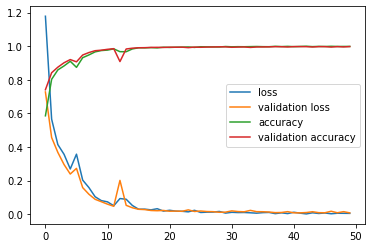

In [13]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='validation loss')
plt.plot(acc, label='accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend()
plt.show()

In [14]:
test_string = "-1"

encoded = encoder.encode(test_string, MAXLEN)

result = model.predict(np.array([encoded]))

#print(np.argmax(result[0], axis=1))
print(encoder.decode(result[0]))

9   


In [15]:
from IPython.display import display
from ipywidgets import interactive, fixed
import ipywidgets as widgets


def i_am_thinking(sequence, trained_model):
    encoded = np.array([encoder.encode(sequence, MAXLEN)])

    result = trained_model.predict(encoded)

    #print(np.argmax(result[0], axis=1))
    print("I think the following number to the sequence", encoder.decode(encoded[0]).strip(), "is", encoder.decode(result[0]).strip())

w = interactive(i_am_thinking,
                sequence=widgets.Text(value='1 2 3 4', placeholder='Insert your sequence here', description='Number sequence', disabled=False),
                trained_model=fixed(model))

display(w)

interactive(children=(Text(value='1 2 3 4', description='Number sequence', placeholder='Insert your sequence h…